<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Trans-Neptunian Objects (TNOs)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run: August 3, 2023 <br>
LSST Science Pipelines version: w_2023_21  <br>
Container Size: medium <br>
Targeted learning level: intermediate<br>

**Description:** Explore the trans-Neptunian object populations in DP0.3. 

**Skills:** Use of the DP0.3 catalogs to study TNO populations.

**LSST Data Products:**  DP0.3 catalogs `SSObject`, `DiaSource`, and `MPCORB` (10-year catalogs).

**Packages:** `lsst.rsp`

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Pedro Bernardinelli (University of Washington), and the Rubin Community Science Team for DP0.3.
This tutorial is primarily based on a Jupyter Notebook by Pedro Bernardinelli, and a Jupyter Notebook by Meg Schwamb. 
This notebook has made use of suggestions in the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist), and has made use of NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a> and <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. 
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

### 1.1 What are Trans-Neptunian objects (TNOs)

A trans-Neptunian object (TNO) is a minor planet within the Solar System which orbits the Sun at an average distance greater than that of Neptune (> 30.11 astronomical units; au). 
The population of TNOs is scientifically valuable because they are largely intact relics from the era of planetary formation. 

In the current model explaining the formation of the outer Solar System, the small building blocks of planets, called planetesimals, that eventually became TNOs can be categorized into two broad groups.

1. **Outwardly Migrated "Hot" TNOs.**
Some planetesimals formed within the inner region of the protoplanetary disk, located at a distance less than 30 au from the Sun. 
These planetesimals were later pushed outward by interactions with a migrating Neptune. 
As a result, they acquired dynamically "hot" orbits, meaning their inclination distribution
includes high inclination objects (beyond 5 degrees), in addition to higher eccentricities. 

2. **In-Situ "Cold" TNOs.**
Other planetesimals formed directly in the trans-Neptunian region, 
where they remain with dynamically "cold" orbits (inclinations < 5 degrees and low ellipticities).


#### 1.1.1 Dynamical classes

In Section 3, clustering within plots of eccentricity or inclination versus semi-major axis
will be used to illustrate the following TNO dynamical classes.

**Resonant TNOs** are currently found in stable mean motion resonances with Neptune, meaning they have a specific orbital relationship with the planet. 
It is presumed that they were transported outward while maintaining their resonant positions as Neptune migrated during the early history of the Solar System.

**Scattering TNOs** can have orbits extending to large distances, but their orbits are currently experiencing significant variations due to perturbations caused by Neptune when their closest distance to the Sun (perihelia $q$) is less than approximately 40 au, closest to Neptune. 
Scattering TNOs are believed to be remnants of a population that was scattered during the early formation of the Solar System and have managed to survive for a long time, and whose orbits are experiencing evolution, primarly due to Neptune. 

**Detached TNOs**, in contrast, have higher perihelia and are dynamically independent from Neptune, as they currently maintain stable orbits that are not significantly influenced by Neptune's gravitational effects.
Detached TNOs might have originated as Scattering TNOs whose perihelia were raised through past resonance interactions with Neptune or through interactions with a distant, massive planet in the outer Solar System (though this hypothetical planet has not been observed yet). 
This class of TNOs is among the most enigmatic one, and the questions about where they formed and how they got to their orbits are still open.

**Extreme TNOs** are characterized by their exceptional distances from the Sun, with semi-major axes ($a$) exceeding 150 au (note that definitions may vary slightly) and $q > 40$ au.
The formation mechanism responsible for producing these distant extreme TNOs remains unclear.
One prominent hypothesis involves the presence of a massive object often referred to as "Planet X" or "Planet 9" situated at approximately 400 - 800 au from the Sun.
The gravitational influence of this hypothetical Neptune-mass planet could have played a significant role in sculpting the distribution of these extreme TNOs, leading to the anisotropies observed in their orbital characteristics. Note that the "extreme" class is composed of a mix of "scattering" and "detached" objects, and is only meanigful in the presence of "Planet 9/X" - if there’s no "Planet 9/X", the "extreme" class is not required; see [Batygin et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhR...805....1B/abstract).

**Classical TNOs** correspond to objects that are not in any of the previous classes, and are situated between Neptune's 3:2 and 2:1 mean motion resonances, at distances ranging from 39 to 47 au, and characterized by low eccentricity ($e \lesssim 0.24$) and inclination ($i \lesssim$ 5 degrees). 
This group is a mix of two types of objects: some are native and remained dynamically "cold," while others were originally "hot" objects that migrated into this region.


#### 1.1.2 Comets
In addition to the TNO dynamical classes, the DP0.3 simulation also includes other types of solar System objects such as long-period comets, and they will also be visualized in section 4. **Comets** are icy objects in space with irregular shapes that orbit the sun in highly-elliptical paths. They come in two types: short-period comets (less than 200 years to orbit) found in the Kuiper Belt beyond Neptune (30 au - 50 au), and long-period comets (over 200 years) that have more random paths and are thought to come from the Oort cloud, far away from the sun. The Oort cloud has not been directly observed, but scientists believe it contains many icy objects.

#### 1.1.3 References

The above information was compiled from the following refrences:

*A Search of the Full Six Years of the Dark Energy Survey for Outer Solar System Objects*, [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract)

*Transneptunian Space*, [Gladmann and Volk (2021), AR&AA](https://ui.adsabs.harvard.edu/abs/2021ARA%26A..59..203G/abstract)

*The Outer Solar System Origins Survey (OSSOS). VII. 800+ Trans-Neptunian Objects — The Complete Data Release*, [Banister et al (2018), ApJS](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...18B/abstract)

*Modern celestial mechanics : aspects of solar system dynamics*, [Mobidelli et al. 2002](https://ui.adsabs.harvard.edu/abs/2002mcma.book.....M/abstract)

### 1.2 Import packages

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, numerical analysis, and astronomical data analysis. The [seaborn](https://seaborn.pydata.org/index.html) libray is a statistical data visualization library baed on `matplotlib`.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for access to the DP0 catalogs.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps
from matplotlib.patches import Polygon
import numpy as np
import seaborn as sns
from lsst.rsp import get_tap_service

### 1.3 Define functions and parameters

The following functions and parameters are defined once, and used throughout this notebook.

**_Parameter_**: `a_Neptune`

Neptune's mean semimajor axis ($a_{Neptune}$) in Astronomical Units (au).

In [2]:
a_Neptune = 30.11

**_Function_**: `estimateDiameter`

Estimate the diameter ($d$), in kilometers, of a Solar System object.
The inputs are the object's absolute H magnitude ($H$) and albedo ($A$).
The term "albedo" refers to the fraction of light reflected, from 0 to 1.

$d = 10^{(3.1236\ -\ 0.5 \log(A)\ -\ 0.2H)}$

This function is used in Section 3.

In [3]:
def estimateDiameter(H, albedo=0.15):
    """
    Return Solar System object size in kilometers.

    Parameters
    ----------
    H : float
        Solar System absolute magnitude
    albedo: float
        Solar system object albedo

    Returns
    -------
    d : float
        Estimated diameter of the object, in kilometers.
    """

    d = np.power(10., 3.1236 - 0.5*np.log10(albedo) - 0.2*H)
    return d

**_Function_**: `qVector`

Compute the three-component coordinate position vector ${\bf{q}} = (q1, q2, q3)$ of an object on the plane of an ellipse where: <br>
$q1 = a (\cos(E) - e)$ <br>
$q2 = a \sqrt{(1 - e^2)} \sin(E)$, and <br>
$q3 = 0$.

The input values are the eccentric anomaly ($E$, describing the position of the object along the orbit), semi-major axis ($a$), and eccentricity ($e$). In this orthogonal reference frame, the origin lies on the focus of the ellipse (where the main body is located), and $q_1$ is oriented towards the pericenter of the orbit (see Chapter 1 of [Mobidelli et al. 2002](https://ui.adsabs.harvard.edu/abs/2002mcma.book.....M/abstract)).

This function is used in Section 4.

In [4]:
def qVector(E, a, e):
    """
    Computes the coordinate vector q =
    (a * (cos(E) - e),
    a * sqrt(1 - e^2) * sin(E), 0),
    on the plane of the ellipse.

    Parameters
    ----------
    E : `float` or `np.array`
        Eccentric anomaly.
    a : `float` or `np.array`
        Semi-major axis.
    e : `float` or `np.array`
        Eccentricity.

    Returns
    -------
    coordinates : `numpy.array`
        Coordinate vector(s) in the plane
        of the ellipse.
    """
    q1 = a * (np.cos(E) - e)
    q2 = a * np.sqrt(1. - e ** 2) * np.sin(E)

    if isinstance(q1, float):
        coordinates = np.array([q1, q2, 0.])
    else:
        coordinates = np.array([q1, q2, np.zeros_like(q1)])
    return coordinates

**_Function_**: `rotationMatrix`

Compute the rotation matrix between the position vector $\bf{q}$ in the plane of the ellipse to a position vector $\bf{r}$ with respect to an arbitrary orthogonal reference frame $(x, y, z)$: 

${\bf{r}} = R_{\rm {xq}} (\Omega, \omega, \textit{i})\ {\bf{q}}$

The rotation matrix is a function of the longitude of the node, $\Omega$, the argument of the perihelion $\omega$, and the orbit incination,  $\textit{i}$. 

Note that this equation provides a one-to-one correspondence between the six orbital elements of an object and the ${\bf{r}}$ position vector.

(see Chapter 1 of [Mobidelli et al. 2002](https://ui.adsabs.harvard.edu/abs/2002mcma.book.....M/abstract)).

This function is used in Section 4.

In [5]:
def rotationMatrix(peri, node, incl):
    """
    Computes the rotation matrix R = R(operi, node, incl) that
    maps from the plane of the ellipse to 3D space aligned
    with the ecliptic plane.

    node : `float`
        Longitude of the node (rad).
    peri : `float`
        Argument of pericenter (rad).
    incl : `float`
        Orbit inclination (rad).
    """
    cO = np.cos(np.pi * node / 180)
    sO = np.sin(np.pi * node / 180)
    co = np.cos(np.pi * peri / 180)
    so = np.sin(np.pi * peri / 180)
    ci = np.cos(np.pi * incl / 180)
    si = np.sin(np.pi * incl / 180)

    R = np.array([[cO * co - sO * so * ci, -cO * so - sO * co * ci, sO * si],
                  [sO * co + cO * so * ci, -sO * so + cO * co * ci, -cO * si],
                  [si * so, si * co, ci]])

    return R

**_Function_**: `fullEllipse`

Compute the coordinates of the each point of the ellipse ("full" ellipse) in an arbitrary coordinate frame ${\bf{r}}=(x,y,z)$, strarting from the coordinates in the plane from the ellipse, ${\bf{q}}=(q_1, q_2, q_3)$, using the rotation matrix defined above:

${\bf{r}} = R_{\rm {xq}} (\Omega, \omega, \textit{i})\ {\bf{q}}$

This function is used in Section 4.

In [6]:
def fullEllipse(a, e, incl, node, peri):
    """ Computes the coordinates of the
    full ellipse in 3D space.

    Parameters
    ----------
    a : `float`
        Semi-major axis (au).
    e : `float`
        Eccentricity.
    incl : `float`
        Orbit inclination (rad).
    node : `float`
        Longitud eof the node (rad).
    peri : `float`
        Argument of the preihelion (rad).

    Returns
    -------
    r : `numpy.array`
        (x, y, z) ellipse coordinates
        in 3D space.

    Notes:
    `E` is the eccentric anomaly.
    """
    E = np.linspace(0, 2 * np.pi, 2000)
    q_vec = qVector(E, a, e)
    Rot = rotationMatrix(peri, node, incl)
    r = np.einsum('ij, j...', Rot, q_vec)

    return r

**_Function_**: `gradientFill`

Plot a line with a linear gradient filled beneath it.

This function is used in Section 3.2 when plotting eccentricy (or inclination) versus semi-major axis, and
was taken from [Stack Overflow](https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib).

In [7]:
def gradientFill(x, y, alpha=1, fill_color=None, ax=None,
                 invert=False, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    alpha : float
        Transparency for plotted element, 0 for transparent, 1 for opaque.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    invert : boolean
        Whether to invert the gradient.

    Additional arguments are passed on to matplotlib's `plot` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, alpha=0, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0, alpha, 100)[:, None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='upper', zorder=zorder)

    xy = np.column_stack([x, y])

    if invert == 0:
        xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmin, ymax], [xmin, ymin]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    return line, im

**_Function_**: `plotResonances`

Calculate mean motion resonances with Neptune and plot them as vertical dashed lines, using $P^2 \propto a^3$.

In [8]:
def plotResonances(ax, k, k_N, y_loc=None, a_shift=0.75, alpha=0.2):
    """Plot Neptune resonances.

    Implements Kepler's Third law
    `a = a_N*(k/k_N)**(2/3)`, where `a`
    is the semi-major axis of a TNO in
    orbital resonance with Neptune in au,
    `a_N` is Neptune's mean semi-major
    axis (`a_N = 30.11` au) and (k/K_N)
    is the orbital period ratio.

    Parameters
    ----------
    ax : `matplotlib...`
    Figure axes.
    k : `int`
       Numerator of the period ratio
       with respect to Neptune's
       orbital period.
    k_N : `int`
        Denominator in period ratio,
        corresponding to Neptune.
    y_loc : `float`
        Location of the vertical line
        showing the resonance.
    alpha : `float`
       Line transparency.

    Returns
    -------
    ax : `matplotlib...`
       Figure axes.
    """
    a_res = a_Neptune * np.cbrt(float(k)**2/float(k_N)**2)
    ax.axvline(a_res, linewidth=2, alpha=alpha, linestyle='--')
    if y_loc is not None:
        ax.annotate(r'${}:{}$'.format(k, k_N),
                    (a_res + a_shift, y_loc),
                    rotation=90, fontsize=12)
    return ax

**_Parameters_**: Set plotting parameters to make visually accessible plots.

In [9]:
params = {'lines.linewidth': 2,
          'lines.linestyle': '-',
          'lines.color': 'black',
          'patch.linewidth': 2,
          'font.family': 'serif',
          'font.weight': 'normal',
          'font.size': 11.0,
          'text.color': 'black',
          'axes.edgecolor': 'black',
          'axes.linewidth': 2.0,
          'axes.grid': False,
          'axes.titlesize': 'large',
          'axes.labelsize': 'large',
          'axes.labelweight': 'bold',
          'axes.labelcolor': 'black',
          'axes.formatter.limits': (-4, 4),
          'xtick.major.size': 10,
          'xtick.minor.size': 5,
          'xtick.major.pad': 8,
          'xtick.minor.pad': 8,
          'xtick.labelsize': 'large',
          'xtick.minor.width': 2.0,
          'xtick.major.width': 2.0,
          'xtick.minor.visible': True,
          'ytick.major.size': 10,
          'ytick.minor.size': 5,
          'ytick.major.pad': 8,
          'ytick.minor.pad': 8,
          'ytick.labelsize': 'large',
          'ytick.minor.width': 1.0,
          'ytick.major.width': 1.0,
          'ytick.minor.visible': True,
          'legend.numpoints': 1,
          'legend.fontsize': 'large',
          'legend.shadow': False,
          'legend.frameon': True,
          'legend.fancybox': True,
          'figure.titlesize': 'large',
          'figure.figsize': (8, 7),
          'figure.facecolor': 'white'}
plt.rcParams.update(params)

## 2. Query the `MPCORB` year 10 catalog for all TNOs

Start the TAP service for DP0.3 Solar System data, ``ssotap``.

In [10]:
service = get_tap_service("ssotap")

The contents of the `MPCORB` table are explored and explained in the introductory DP0.3 notebook. In this notebook, we willl use the year 10 catalog, `dp03_catalogs_10yr.MPCORB`. A year 1 catalog is also availabe (`dp03_catalogs_1yr.MPCORB`) 

**Option:** Uncomment the following cell to view the column descriptions for the `MPCORB` catalog as a `pandas` table.

In [11]:
# results = service.search("SELECT column_name, datatype, description, "
#                         "unit from TAP_SCHEMA.columns "
#                         "WHERE table_name = 'dp03_catalogs_10yr.MPCORB'")
# results.to_table().to_pandas()

### 2.1 Create and execute the query

Create a query that will retrive the Solar System object ID (`ssObjectid`);
five orbital elements eccentricity (`e`), 
inclination (`incl`; degrees),
perihelion distance (`q`; au),
longitude of the ascending node (`node`; degrees), 
and argument of the perihelion (`peri`; degrees);
and the MPC's measured absolute $H$ and $G$ magnitudes (`mpcH` and `mpcG`).

**Orbital elements:**
For a refresher on what each orbital element means, the 
[Wikipedia page for orbital elements](https://en.wikipedia.org/wiki/Orbital_elementshttps://en.wikipedia.org/wiki/Orbital_elements)
is a good place to start and has an informative diagram.

**Absolute $H$ magnitudes:**
For Solar System objects, absolute $H$ magnitudes are defined to be for an object 1 au from the Sun and 1 au 
from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.
Absolute $H$ magnitudes (`mpcH` in the `MPCORB` table) are derived by correcting for distance, fitting a function to the relationship between
absolute magnitude and phase (the slope of which is referred to as the $G$ magnitude; `mpcG` in the `MPCORB` table), 
and evaluating the function at a phase of 0 deg.
The $H$ and $G$ magnitudes in different filters can reveal the the surface properties and composition of asteroids.
The $H$ magnitude is specifically used for objects that primarily reflect sunlight, such as asteroids, since their brightness depends on their distance from the Sun and the observer, 
and their "albedo" (the fraction of light reflected, from 0 to 1; see Section 3).

**Minimum semi-major axis:**
TNOs, by definition, have a semi-major axis greater than the mean semi-amjor axis of Neptune, 30.11 au (`a_Neptune`).
The semi-major axis ($a$) is not included in the `MPCORB` table because it
can be derived from the eccentricity and perihelion distance as $a = \frac{q}{1-e}$.
Include a constraint in the query to only return objects with semi-major axes greater than this limit:<br>
`WHERE (mpc.q / (1 - mpc.e) > {a_Neptune})`.

**Minimum number of observations:**
In order to robustly measure the absolute $H$ magnitudes and the orbital elements for a TNO,
multiple observations over time are required. 
The minimum number of observations needed for a given analysis will depend on the science goals
and the precision required, and is ultimately left to the discretion
of the scientist.
Here, as an example, use a limit of 10 observations (`min_num_obs`).
The number of observations are stored in the `numObs` column of the `SSObject` table,
so including this constraint requires a `JOIN` with this table.

**Maximum eccentricity:**
Finally, include the constraint that the eccentricity must be less than 1 to reject any 
TNOs with catastrophic failures in eccentricity calculations. 

**Execute the query:**
The following query returns 27233 TNOs, which is about an order of magnitude greater than 
the current number of confirmed TNOs, and is consistent with expectations and forecast for LSST Y10.

In [12]:
min_num_obs = 10
tnos = service.search("SELECT mpc.ssObjectId, mpc.e, mpc.incl, mpc.q, "
                      "mpc.node, mpc.peri, mpc.mpcH, mpc.mpcG "
                      "FROM dp03_catalogs_10yr.MPCORB as mpc "
                      "JOIN dp03_catalogs_10yr.SSObject as sso "
                      "ON mpc.ssObjectId = sso.ssObjectId "
                      f"WHERE (mpc.q / (1 - mpc.e) > {a_Neptune}) "
                      f"AND sso.numObs > {min_num_obs} "
                      "AND mpc.e < 1 ").to_table()
print(len(tnos))

27233


### 2.1 Calculate semi-major axis

Calculate the semi-major axis, `a`, for all TNOs and add it to the table.

In [13]:
tnos['a'] = tnos['q'] / (1.0 - tnos['e'])

## 3. Explore the dynamical classes of TNOs

The dynamical classes of TNOs are defined by their orbital parameters, 
which show clustering in the parameter space of eccentricity or inclination
versus semi-major axis.

To first explore the relationships between these orbital parameters,
plot all of the TNOs together by executing the cell below.

After, uncomment the two lines to `set_ylim` and `set_xlim`, and re-execute the following cell,
to further zoom in and view the clustering in parameter space.

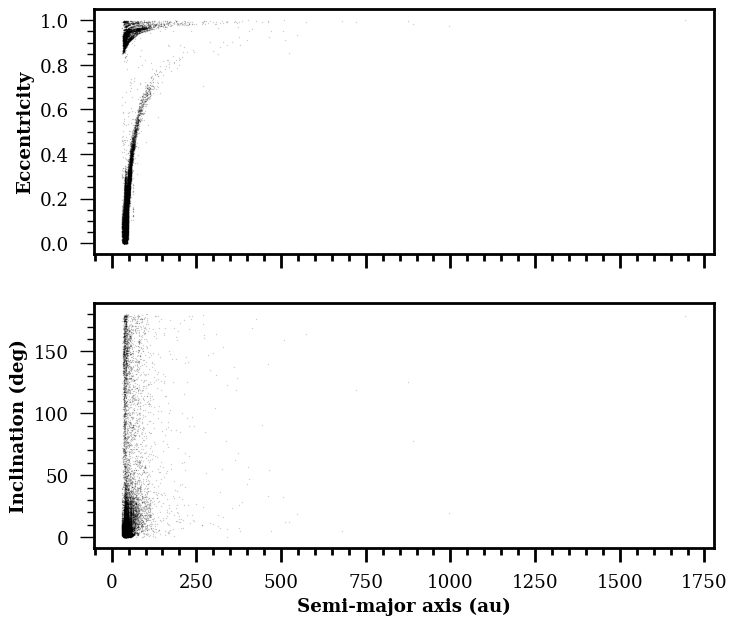

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(tnos['a'], tnos['e'], '.', ms=2, alpha=0.2, mew=0, color='black')
ax1.set_ylabel('Eccentricity')

ax2.plot(tnos['a'], tnos['incl'], '.', ms=2, alpha=0.2, mew=0, color='black')
ax2.set_ylabel('Inclination (deg)')
ax2.set_xlabel('Semi-major axis (au)')

# ax1.set_ylim([-0.03, 0.7])
# ax2.set_xlim([28, 100])

plt.show()

Let's now use the `seaborn` statistical visualization libray to plot plot the eccentricy and inclination as function of semi-major axis in a different way, focusing on objects with `a` less than 70 au.  

Text(0, 0.5, 'inclination (degrees)')

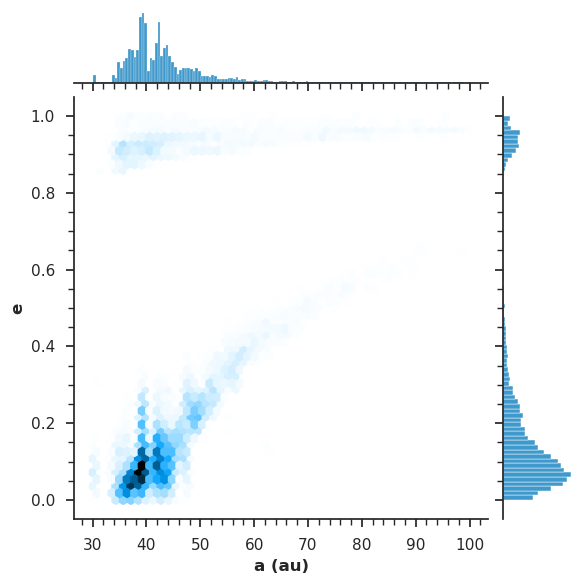

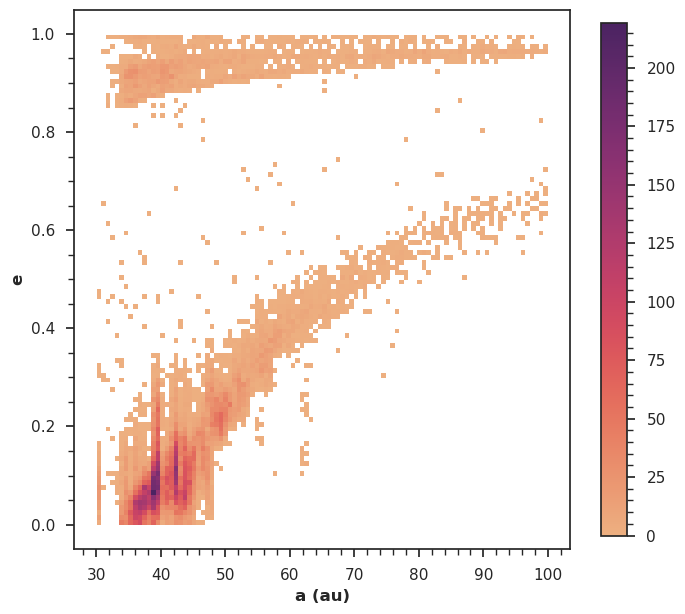

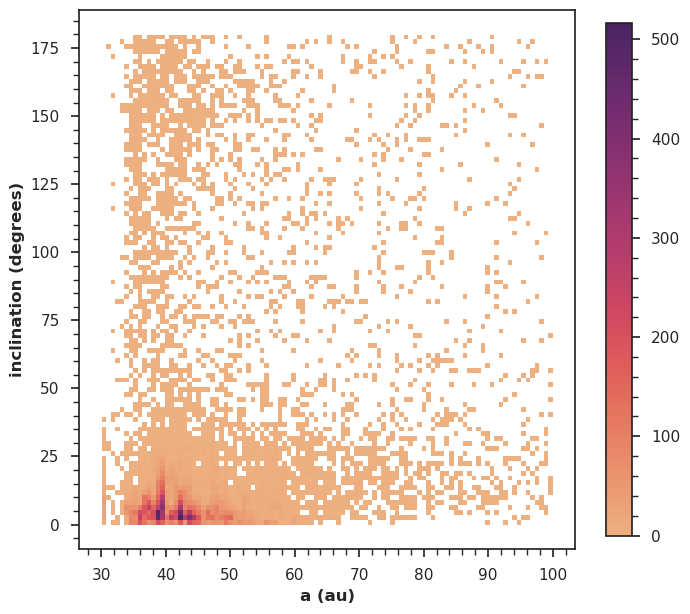

In [18]:
sns.set(style="ticks")
tmp=tnos[tnos['a']<=70]
sns.jointplot(x=tmp['a'], y=tmp['e'], kind="hex", color="#0077BB", gridsize=50)
plt.xlabel('Semi-major axis (au)')
plt.ylabel('')

plt.figure()
sns.histplot(x=tmp['a'], y=tmp['e'], bins=100, cmap="flare",  cbar=True, cbar_kws=dict(shrink=.95))
plt.xlabel('Semi-major axis (au)')

plt.figure()

sns.histplot(x=tmp['a'], y=tmp['incl'], bins=100, cmap="flare",  cbar=True, cbar_kws=dict(shrink=.95))
plt.xlabel('a (au)')
plt.ylabel('inclination (degrees)')

**Why is there clustering in semi-major axis?**

The clustering in semi-major axis is due to *resonances*.
Since Neptune is so much more massive than a TNO, it influences the regions
of orbital element parameter space that are stable, 
and orbits that are "in resonance with Neptune" are stable orbits for TNOs.

TNOs with orbital periods that are in, for example, a 1:1 resonance with Neptune
have the same period, $P$, and thus same semi-major axis, $a$, because $P^2 \propto a^3$.
TNOs in a 2:1 resonance with Neptune have double the period, and thus $\sqrt[3]{4}$ times
the semi-major axies, which is $\sim47$ au.
The population of 2:1 resonant TNOs at $\sim47$ au$\sim47$ au will be labeled in the plot in Section 3.2 below.

### 3.1 Use known dynamical class boundaries to identify members

Below, define the boundaries to clasify the TNOs in the following dynamical classes: 
scattering, detached, classical, and extreme. 

> **Warning**: In the literature, class definitions may vary!
This notebook is using definitions to match the dynamical classifications in [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract),
which found 814 TNOs in the Dark Energy Survey Year 6 data,
in order to recreate their Figure 8 below. Note that the class boundaries are not "fixed" but rather "fluid" - the cell below uses approximate definitions. The actual dynamical classification process is performed in terms of orbits solutions (integration); see [Gladmann et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ssbn.book...43G/abstract) and [Gladmann and Volk (2021)](https://ui.adsabs.harvard.edu/abs/2021ARA%26A..59..203G/abstract).

In [54]:
max_a_classical = 47
min_a_classical = 40
max_e_classical = 0.24
mask_classical = ((tnos['a'] >= min_a_classical)
                  & (tnos['a'] <= max_a_classical)
                  & (tnos['e'] <= max_e_classical))

min_q_detached = 38
mask_detached = ((tnos['a'] > max_a_classical)
                 & (tnos['e'] > max_e_classical)
                 & (tnos['q'] >= min_q_detached))

mask_scattering = ~mask_classical & (tnos['q'] < min_q_detached)

min_a_extreme = 150
min_q_extreme = 30
mask_extreme = (tnos['a'] > min_a_extreme) & (tnos['q'] > min_q_extreme)

max_q_comets = 10
mask_comets = tnos['q'] < max_q_comets

Create a new array called `classes` that contains strings labeling the dynamical class for each object. Initialize this array with the string "Other" to cover unclassified TNOs.

In [55]:
other_string = 'Other     '
classes = np.repeat(other_string, len(tnos))

In [56]:
classes[mask_classical] = 'Classical'
classes[mask_detached] = 'Detached'
classes[mask_scattering] = 'Scattering'
classes[mask_extreme] = 'Extreme'
classes[mask_comets] = 'Comets'


Take the whitespace out of the string where `classes` = 'Other'.

In [57]:
tx = np.where(classes == other_string)[0]
classes[tx] = 'Other'
del tx

Add the contents of the `classes` array as a new column to the TNO table.

In [58]:
tnos['class'] = classes

Confirm that the only unique values of the `class` column are the five classes defined above.

Print the number of TNOs identified as each class.

In [59]:
class_strings, class_counts = np.unique(tnos['class'], return_counts=True)
for s, string in enumerate(class_strings):
    print('%-12s %6i' % (class_strings[s], class_counts[s]))

Classical      8530
Comets         3351
Detached        547
Extreme          32
Other          1835
Scattering    12938


### 3.2 Visualize the dynamical classes

Define five colors, markers, and line styles to use, one set for each class.

In [60]:
class_to_format = {'Other': ('xkcd:black', 'x', (0, (1, 10))),
                   'Classical': ('xkcd:light purple', 's', 'dotted'),
                   'Detached': ('xkcd:light orange', '+', 'dashed'),
                   'Extreme': ('xkcd:scarlet', 'D', 'dashdot'),
                   'Scattering': ('xkcd:cerulean blue', '.', 'solid'),
                   'Comets': ('xkcd:teal', '^', (5, (10, 3)))}

Recreate Figure 8 from 
[Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract),
but impose a limit on semi-major axis of 100 au which excludes the "Extreme" dynamical class.

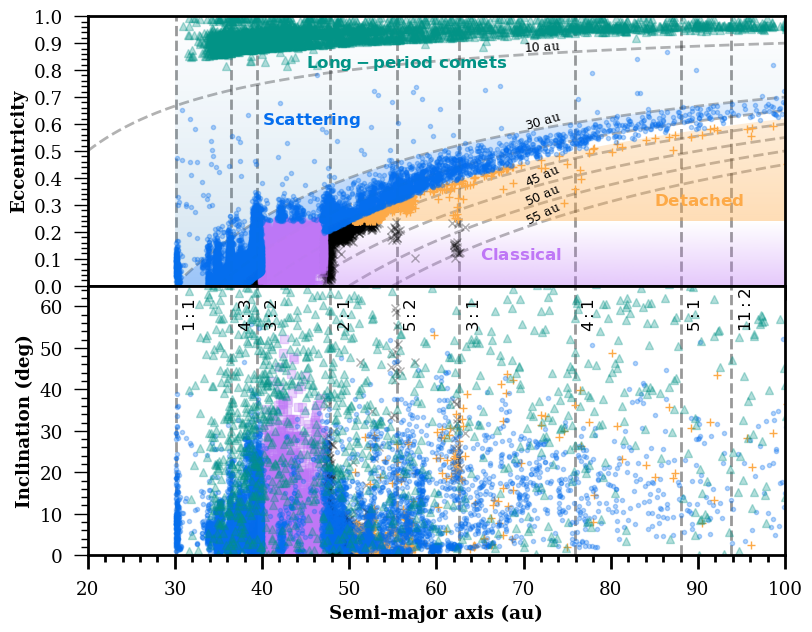

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(9, 7)
plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["image.composite_image"] = False
e = np.linspace(0, 0.99999, 10000)

for q in [10, 30, 35, 40, 45, 50, 55]:
    ax1.plot(q / (1 - e), e, 'k--', alpha=0.3)

for i, j in zip([1, 2, 3, 3, 4, 4, 5, 5, 11],
                [1, 1, 1, 2, 1, 3, 2, 1, 2]):
    ax1 = plotResonances(ax1, i, j, alpha=0.4)
    ax2 = plotResonances(ax2, i, j, y_loc=55, alpha=0.4)

gradientFill(30 / (1 - e), e, ax=ax1, alpha=0.2, invert=True)
color, marker, _ = class_to_format['Detached']
gradientFill(min_q_detached / (1 - e)[e > max_e_classical],
             e[e > max_e_classical],
             ax=ax1, alpha=0.4, color=color, marker=marker)

scat = np.append(30 / (1 - e), 35 / (1 - e)[::-1])
scat_e = np.append(e, e[::-1])
color, marker, _ = class_to_format['Scattering']
gradientFill(scat, scat_e, ax=ax1, alpha=0.4,
             color=color, marker=marker)

cl = np.append(35 / (1 - e)[e < max_e_classical], 100)
e_cl = np.append(e[e < max_e_classical], 0.24)
color, marker, _ = class_to_format['Classical']
gradientFill(cl, e_cl, ax=ax1, alpha=0.4, color=color, marker=marker)

for c in class_to_format.keys():
    b = tnos[tnos['class'] == c]
    use_alpha = 0.3
    if c == 'Detached':
        use_alpha = 1
    color, marker, _ = class_to_format[c]
    ax1.plot(b['a'], b['e'], marker, alpha=use_alpha, color=color)
    ax2.plot(b['a'], b['incl'], marker, alpha=use_alpha, color=color)

fontsize_labels = 12
ax1.text(45, 0.81, r'$\bf{Long-period\ comets}$', rotation=0,
         color=class_to_format['Comets'][0], fontsize=fontsize_labels)
ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0,
         color=class_to_format['Scattering'][0], fontsize=fontsize_labels)
ax1.text(85, 0.3, r'$\bf{Detached}$', rotation=0,
         color=class_to_format['Detached'][0], fontsize=fontsize_labels)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0,
         color=class_to_format['Classical'][0], fontsize=fontsize_labels)

fontsize_q_text = 9
ax1.text(70, 0.23, r'$55$ au', rotation=25, fontsize=fontsize_q_text)
ax1.text(70, 0.3, r'$50$ au', rotation=23, fontsize=fontsize_q_text)
ax1.text(70, 0.37, r'$45$ au', rotation=24, fontsize=fontsize_q_text)
ax1.text(70, 0.58, r'$30$ au', rotation=16, fontsize=fontsize_q_text)
ax1.text(70, 0.87, r'$10$ au', rotation=3, fontsize=fontsize_q_text)

ax2.set_xlabel('Semi-major axis (au)')
ax1.set_ylabel('Eccentricity')
ax2.set_ylabel('Inclination (deg)')

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 65)
ax1.set_xlim(20, 100)
ax2.set_xlim(20, 100)

ax1.set_xticks(np.arange(20, 110, 10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 70, 10))

plt.show()

Let's now extend the previous plot in semi-major axies to include "extreme" TNOs and more long-period comets.

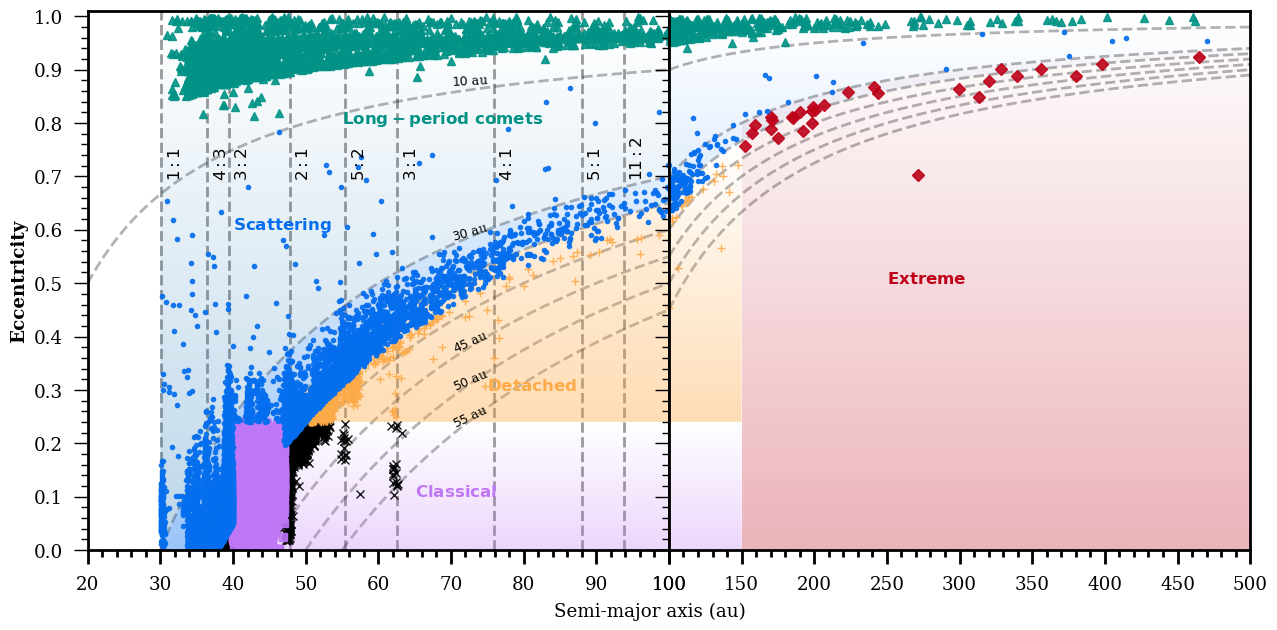

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15, 7)
plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams["image.composite_image"] = False
e = np.linspace(0, 0.9999999, 10000)

for q in [10, 30, 35, 40, 45, 50, 55]:
    ax1.plot(q / (1 - e), e, 'k--', alpha=0.3)
    ax2.plot(q / (1 - e), e, 'k--', alpha=0.3)

for i, j in zip([1, 2, 3, 3, 4, 4, 5, 5, 11],
                [1, 1, 1, 2, 1, 3, 2, 1, 2]):
    ax1 = plotResonances(ax1, i, j, 0.7, alpha=0.4)

gradientFill(30 / (1 - e), e, ax=ax1, alpha=0.3, invert=True)

a_det = 35 / (1 - e)[e > max_e_classical]
e_det = e[e > max_e_classical]
color, marker, _ = class_to_format['Detached']
gradientFill(a_det, e_det, ax=ax1,
             alpha=0.4,
             color=color, marker=marker)
gradientFill(a_det[a_det < 150], e_det[a_det < 150], ax=ax2,
             alpha=0.4,
             color=color, marker=marker)

scat = np.append(30/(1-e), 35/(1-e)[::-1])
scat_e = np.append(e, e[::-1])
color, marker, _ = class_to_format['Scattering']
gradientFill(scat, scat_e, ax=ax1, alpha=0.4,
             color=color, marker=marker)
gradientFill(scat, scat_e, ax=ax2, alpha=0.4,
             color=color, marker=marker)
gradientFill(30 / (1 - e), e, ax=ax2, alpha=0.4, invert=True,
             color=color, marker=marker)

cl = np.append(35 / (1 - e)[e < 0.24], 150)
msk = cl < 151
e_cl = np.append(e[e < 0.24], 0.24)
color, marker, _ = class_to_format['Classical']
gradientFill(cl, e_cl, ax=ax1, alpha=0.3,
             color=color, marker=marker)
gradientFill(cl[msk], e_cl[msk], ax=ax2, alpha=0.3,
             color=color, marker=marker)

a_ext = min_q_extreme / (1 - e)
color, marker, _ = class_to_format['Extreme']
gradientFill(np.append(150, a_ext[a_ext > 150]),
             np.append(0, e[a_ext > 150]), ax=ax2,
             alpha=0.3, color=color, marker=marker)

for c in class_to_format.keys():
    b = tnos[tnos['class'] == c]
    use_alpha = 0.9
    color, marker, _ = class_to_format[c]
    ax1.plot(b['a'], b['e'], marker, alpha=use_alpha, color=color)
    ax2.plot(b['a'], b['e'], marker, alpha=use_alpha, color=color)

fontsize_labels = 12
ax1.text(55, 0.80, r'$\bf{Long-period\ comets}$', rotation=0,
         color=class_to_format['Comets'][0], fontsize=fontsize_labels)
ax1.text(40, 0.6, r'$\bf{Scattering}$', rotation=0,
         color=class_to_format['Scattering'][0], fontsize=fontsize_labels)
ax1.text(75, 0.3, r'$\bf{Detached}$', rotation=0,
         color=class_to_format['Detached'][0], fontsize=fontsize_labels)
ax1.text(65, 0.1, r'$\bf{Classical}$', rotation=0,
         color=class_to_format['Classical'][0], fontsize=fontsize_labels)
ax2.text(250, 0.5, r'$\bf{Extreme}$', rotation=0,
         color=class_to_format['Extreme'][0], fontsize=fontsize_labels)

fontsize_q_text = 9
ax1.text(70, 0.23, r'$55$ au', rotation=25, fontsize=fontsize_q_text)
ax1.text(70, 0.3, r'$50$ au', rotation=23, fontsize=fontsize_q_text)
ax1.text(70, 0.37, r'$45$ au', rotation=24, fontsize=fontsize_q_text)
ax1.text(70, 0.58, r'$30$ au', rotation=16, fontsize=fontsize_q_text)
ax1.text(70, 0.87, r'$10$ au', rotation=3, fontsize=fontsize_q_text)

fig.supxlabel('Semi-major axis (au)')
ax1.set_ylabel('Eccentricity')
ax1.set_ylim(0, 1.01)
ax1.set_xlim(20, 100)
ax2.set_xlim(100, 500)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
plt.show()

### 3.3 Characterize the dynamical classes

For the "Classical", "Detached", and "Scattering" classes of TNOs, compare distributions of their
orbital elements, estimated diameters, and absolute $H$ magnitudes from the `MPCORB` catalog.

Note that in DP0.3 data, the `SSObject` table does not contain any _LSST-measured_ absolute $H$ magnitudes
in the LSST's $ugrizy$ filters.
The reason why (noisy phase curves) will be demonstrated in Section 5.

#### 3.3.1 Orbital elements

In the following cells, we will plot histograms of the two orbital elements that have not yet been explored:
the longitude of the ascending node (`node`; degrees) and the argument of the perihelion (`peri`; degrees). 

We will use alogarithmic scale in the y-axis to simultaneously show the different populations.

Notice that the distributions for both the `node` and the `peri` for "Classical", "Detached", "Scattering",  and "Other" are all quite flat, but that the distribution for the "Extreme" objects  seem to be clustered at certain values. 

The apparent clustering in longitude of perihelion `node` and ascending node `peri` of "extreme" TNOs motivated the hypothesis that the solar system contains a 5–10 Earth-mass planet (Planet X/Planet 9) at 400–800 times Earth's distance from the Sun ([Trujillo & Sheppard 2014](https://ui.adsabs.harvard.edu/abs/2014Natur.507..471T/abstract); [Batygin & Brown 2016](https://ui.adsabs.harvard.edu/abs/2016AJ....151...22B/abstract); [Batygin et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhR...805....1B/abstract)). 

However, this hypothesis is still under debate (e.g., [Napier et al. 2021](https://ui.adsabs.harvard.edu/abs/2021PSJ.....2...59N/abstract)), and a statistical analysis that demonstrates whether this apparent clustering could be attributed to small-numbers of objects or not is beyond the scope of this tutorial. 

Additionally, caution must be exercised when interpreting these results, as the observed clustering could potentially stem from a selection bias. It may be an artifact of the type of model used as inputs for Trans-Neptunian Objects (TNOs) in the "MPCORB" catalog. This catalog is a hybrid one that employs a pre-defined population model known as the "Synthetic Solar System Model, S3M" [Grav et al. 2011](https://iopscience.iop.org/article/10.1086/659833/meta), wherein model objects are replaced with real, existing objects currently listed in the Minor Planet Center. Consequently, the statistics are influenced by the S3M properties. While the model adequately produces populations for TNOs, it does not fully capture the properties of certain solar system objects, such as "extreme" TNOs, many of which have been discovered since 2011 (after the paper's publication) thanks to surveys like _OSSOS_ or _DES_.

Exclude the comets, which belong to a different type of solar system objects. 

In [63]:
classes_tnos = ['Other', 'Classical', 'Detached', 'Extreme', 'Scattering']

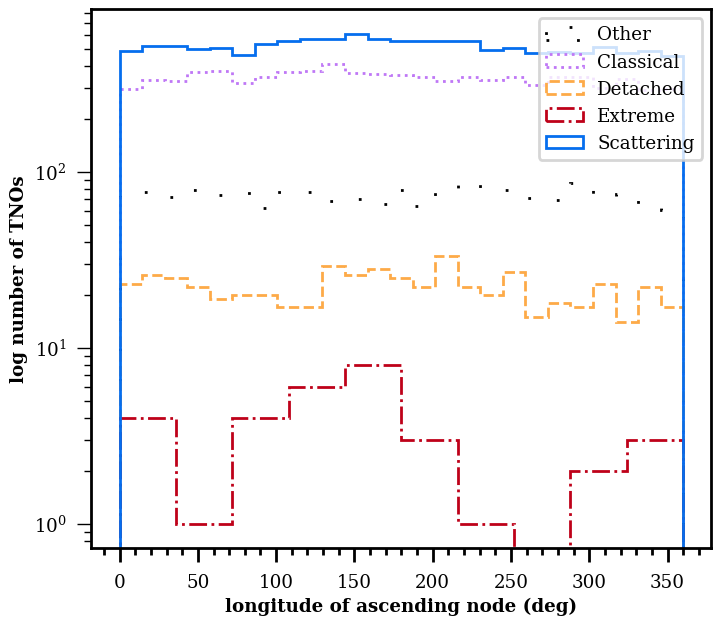

In [64]:
for label in classes_tnos:
    if label == 'Extreme':
        nbins = 10
    else:
        nbins = 25
    tx = np.where(tnos['class'] == label)[0]
    color, _, linestyle = class_to_format[label]
    plt.hist(tnos['node'][tx], bins=nbins, range=(0, 360),
             histtype='step', log=True,
             color=color, label=label,
             linestyle=linestyle)
plt.xlabel('longitude of ascending node (deg)')
plt.ylabel('log number of TNOs')
plt.legend(loc='best')
plt.show()

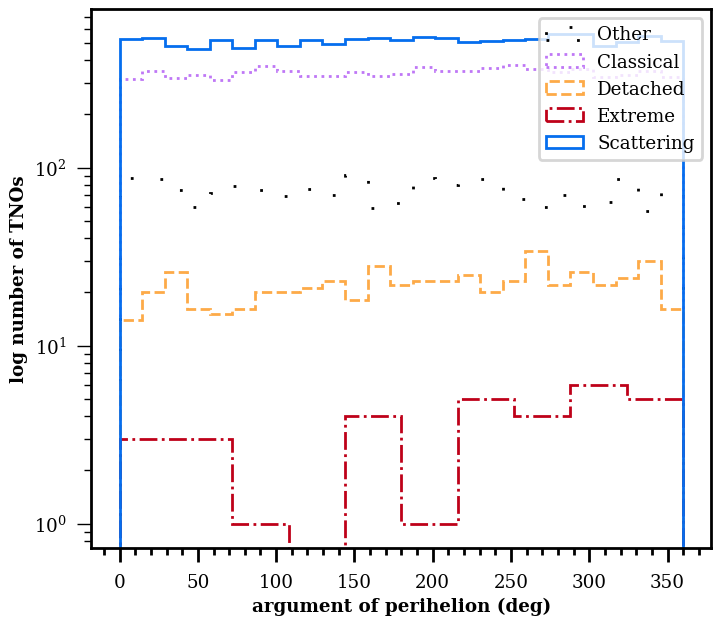

In [65]:
for label in classes_tnos:
    if label == 'Extreme':
        nbins = 10
    else:
        nbins = 25
    tx = np.where(tnos['class'] == label)[0]
    color, _, linestyle = class_to_format[label]
    plt.hist(tnos['peri'][tx], bins=nbins, range=(0, 360),
             histtype='step', log=True,
             color=color, label=label,
             linestyle=linestyle)
plt.xlabel('argument of perihelion (deg)')
plt.ylabel('log number of TNOs')
plt.legend(loc='best')
plt.show()

#### 3.3.2 Estimated diameters

Estimate the diameter of all TNOs using an assumed mean albedo of 0.1 (see [Vilenius et al. 2012](https://ui.adsabs.harvard.edu/abs/2012A%26A...541A..94V/abstract) for measurements of and discussion about TNO's geometric albedos).

In [66]:
tnos['d'] = estimateDiameter(tnos['mpcH'], albedo=0.1)

Plot the estimated size distribution for these TNOs.

Notice that the x-axis limit is set to 400 km.
Adjust the limits to explore TNOs with larger estimated radii.

Compared to the "classical" population, the "detached" objects are expected to have larger sizes (smaller H magnitude), whereas the "scattering" population is expected to ave smaller sizes (larger H magnitudes). 

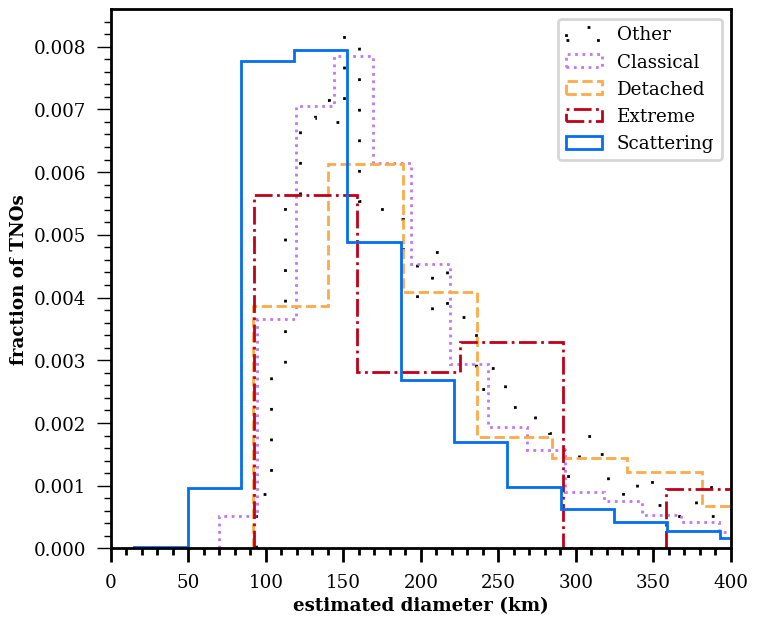

In [67]:
for label in classes_tnos:
    if label == 'Extreme':
        nbins = 30
    else:
        nbins = 150
    tx = np.where(tnos['class'] == label)[0]
    color, _, linestyle = class_to_format[label]
    plt.hist(tnos['d'][tx], bins=nbins, histtype='step',
             density=True, color=color, label=label,
             linestyle=linestyle)
plt.xlabel('estimated diameter (km)')
plt.ylabel('fraction of TNOs')
plt.xlim([0, 400])
plt.legend(loc='upper right')
plt.show()

#### 3.3.3 Absolute magnitude

Print to screen the minimum and maximum values of 
the MPC absolute $G$ magnitudes, and notice that the MPC assumes a slope 
of $G=0.15$ for all DP0.3 TNOs.
It is not worth creating a plot of the distribution for absolute $G$ magnitudes.

In [68]:
for label in class_to_format.keys():
    tx = np.where(tnos['class'] == label)[0]
    print('%-12s   min G = %4.2f   max G = %4.2f' %
          (label, np.min(tnos['mpcG'][tx]), np.max(tnos['mpcG'][tx])))

Other          min G = 0.15   max G = 0.15
Classical      min G = 0.15   max G = 0.15
Detached       min G = 0.15   max G = 0.15
Extreme        min G = 0.15   max G = 0.15
Scattering     min G = 0.15   max G = 0.15
Comets         min G = 0.15   max G = 0.15


We will now plot the cumulative distribution of MPC absolute $H$ magnitudes for these TNOs, in the next cell. Notice the tail to bright magnitudes for detached objects, similar
as the tail to objects with larger size estimates above.

As in section 5.1 of [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract), cumulative plots such as the one in the next cell can be used to test models of TNO formation, such as the CFEPS-L7 model ([Kavelaars et al. 2009](https://ui.adsabs.harvard.edu/abs/2009AJ....137.4917K/abstract); [Petit et al.
2011](https://ui.adsabs.harvard.edu/abs/2011AJ....142..131P/abstract); [Gladman et al. 2012](https://ui.adsabs.harvard.edu/abs/2012AJ....144...23G/abstract)) for "Classical" TNOs; see Fig. 10 of [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract).

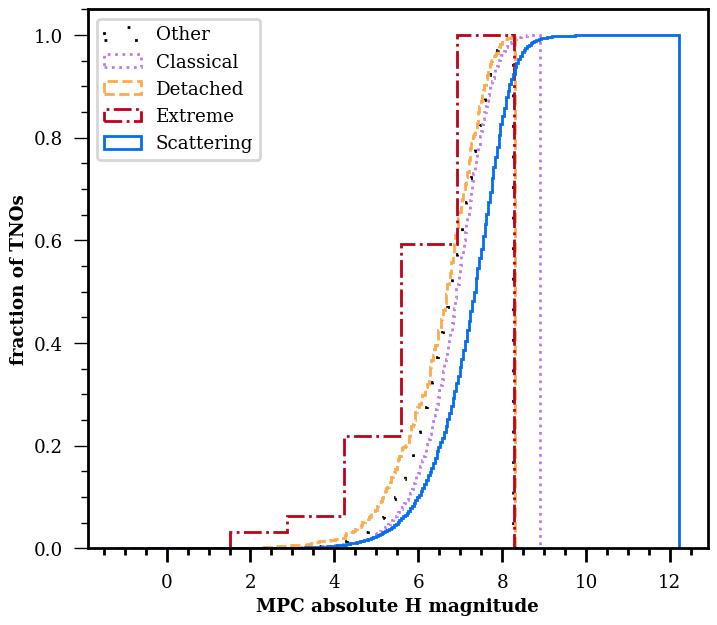

In [69]:
for label in classes_tnos:
    if label == 'Extreme':
        nbins = 5
    else:
        nbins = 300
    color, _, linestyle = class_to_format[label]
    tx = np.where(tnos['class'] == label)[0]
    plt.hist(tnos['mpcH'][tx], bins=nbins, histtype='step', density=True,
             color=color, label=label,
             linestyle=linestyle, cumulative=True)
plt.xlabel('MPC absolute H magnitude')
plt.ylabel('fraction of TNOs')
plt.legend(loc='upper left')
plt.show()

#### 3.3.4 Summary

The distributions of TNO orbital parameters and properties, such as the absolute magnitude $H$, offer valuable insights into the physical characteristics and evolution of various TNO dynamical classes. Additionally, they contribute to our understanding of the formation and evolution of the Solar System as a whole. While a detailed interpretation of the reasons behind these distribution differences among the various TNO dynamical classes and how they relate to different formation models exceeds the scope of this tutorial, it remains an ongoing area of research in planetary science. 

## 4. Visualize orbits for each dynamical class

Use the Minor Planet Center-derived orbital elements from the TNOs to visualize their orbits, 
and look for patterns in orbits of different dynamical classes.

### 4.1 Calculate the full orbital ellipse per object

Calculate the full ellipse of the orbit for each TNO, based on their
orbital elements, using the `fullEllipse` function. 
Add the full ellipse to the `tnos` table as a new column.

In [70]:
temp = []
for tno in tnos:
    temp.append(fullEllipse(tno['a'], tno['e'], tno['incl'],
                            tno['node'], tno['peri']))
tnos['fullEllipse'] = temp
del temp

Plot the full ellipse for the first 100 objects, as an example.

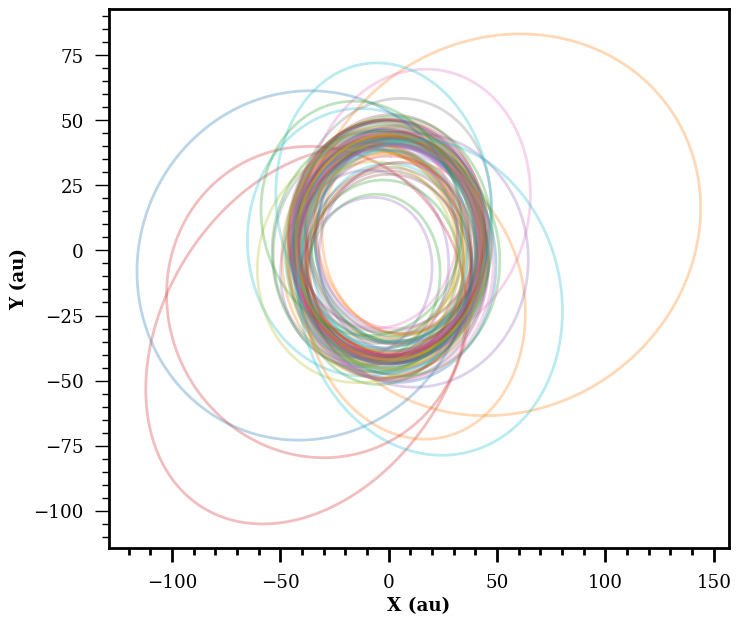

In [71]:
for tno in tnos[:100]:
    plt.plot(tno['fullEllipse'][:, 0], tno['fullEllipse'][:, 1],
             alpha=0.3)
    plt.xlabel("X (au)")
    plt.ylabel("Y (au)")

### 4.2 Illustrate the orbits of each dynamical class

Plot the first 10 examples of orbits in each dynamical class in a 2x2 grid. Note how the orbits for teh "Classical" objects are more circular, whereas the orbits for the other classes are more eccentric.

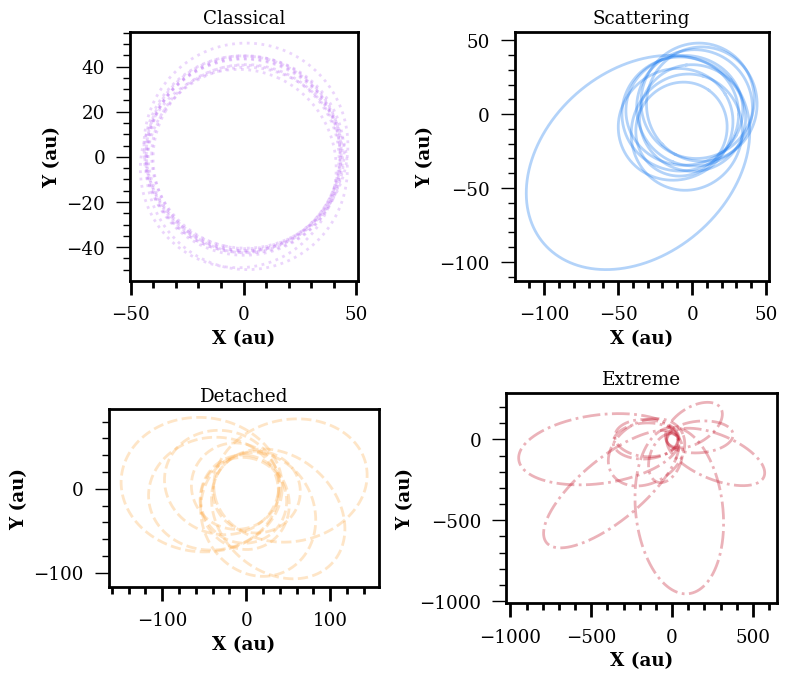

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7))
plt.rcParams["image.composite_image"] = False

classes = ['Classical', 'Scattering', 'Detached', 'Extreme']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for use_class, (row, col) in zip(classes, positions):
    color, _, linestyle = class_to_format[use_class]
    current_ax = ax[row, col]
    current_ax.set_title(f'{use_class}')
    current_ax.set_xlabel('X (au)')
    current_ax.set_ylabel('Y (au)')
    # Plot up to 10 instances of the current class
    for tno in tnos[tnos['class'] == use_class][:10]:
        current_ax.plot(tno['fullEllipse'][:, 0], tno['fullEllipse'][:, 1],
                        color=color, linestyle=linestyle, alpha=0.3,
                        label=use_class)
    current_ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 5. Visualize a TNO in the deep drilling field

Since TNOs are located at a considerable distance from Earth, they exhibit slow motion across the sky, with shifts as small as a few degrees over the 10-year duration of the LSST. The [LSST Deep Drilling Fields](https://www.lsst.org/scientists/survey-design/ddf), each covering an area equivallent to the field-of-view of the LSST Camera (9.6 square degrees), receive thousands of visits or observations throughout the 10-year survey period. Consequently, a single TNO can accumulate a substantial number of observations due to its extended visibility over this extended timeframe. In this section we will follow Section 2 of DP0.3 Portal Tutorial 3, and select a particular TNO from the `dp03_catalogs_10yr.DiaSource` catalogto visualize its orbit in space as a function of time. 

First, we'll do a query that will get all the TNOs with the most number of observations, singling out a particular TNO with `ssObjectId = -735085100561880491`. We will also select `midPointMjdTai`, which is the effective mid-exposure time for this source (in days) to illustrate how the object moves across the sky.  

In [73]:
my_object = service.search("SELECT ra, dec, midPointMjdTai "
                           "FROM dp03_catalogs_10yr.DiaSource "
                           "WHERE ssObjectId = -735085100561880491").to_table()

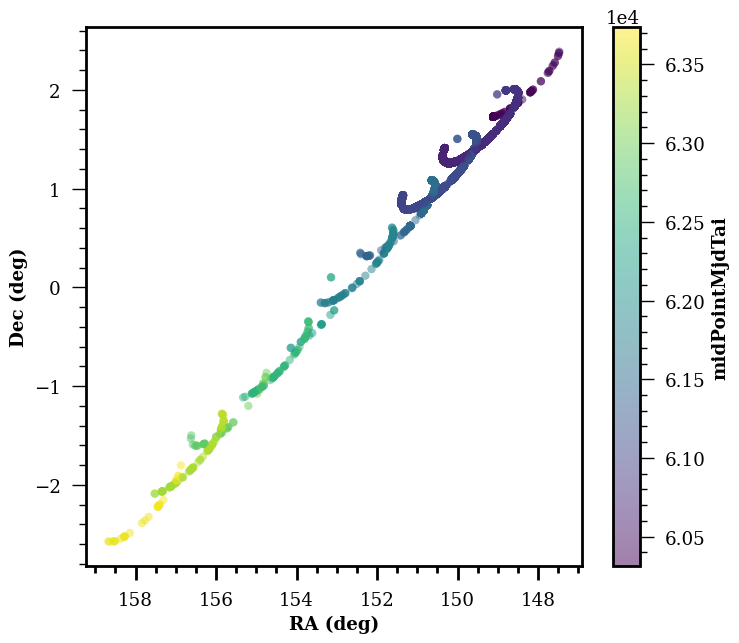

In [74]:
plt.scatter(my_object['ra'], my_object['dec'],
            c=my_object['midPointMjdTai'],
            cmap='viridis', alpha=0.5, edgecolors='none')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.gca().invert_xaxis()
plt.colorbar(label='midPointMjdTai')
plt.show()

As pointed out inthe DP0.3 Portal Tutorial 3, the loops in the object's path on the sky is a result of Earth's orbital period and the 10-year LSST duration.

## 6. Exercises for the learner

1. In section 3, the "Resonant" TNOs were labeled among the "Others" class. Define cuts to identify these resonant objects based on the resonances shown in the the `e-incl-a` plot of section 3.2.
Assign them a new class label within the TNO table, and visualize them in the `e-incl-a` plot, as in Fig. 8 of [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract).

2. In section 3.3.2 we used the absolute magnitude $H$ - size relation assuming a mean albedo of 0.1 for all dynamical classes.
[Vilenius et al. 2012](https://ui.adsabs.harvard.edu/abs/2012A%26A...541A..94V/abstract) provide mode detailed distributions and albedo measurenets. Try estimating TNOS sizes with different albedos.

3. Section 3.3.3 calculated the cumulative distribution of $H$.
Calculate the cumulative distributions for other orbital parameters and compare to section 5.1 of [Bernardinelli et al. (2022), ApJS](https://ui.adsabs.harvard.edu/abs/2022ApJS..258...41B/abstract).